In [8]:
import json
import time
from typing import Dict

from datasets import load_dataset, load_from_disk# type: ignore
from datasets.formatting.formatting import LazyBatch # type: ignore
from huggingface_hub import list_datasets # type: ignore
import matplotlib.pyplot as plt
from minio import Minio
from minio.datatypes import Object
from minio.helpers import ObjectWriteResult
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
from transformers import AutoModel, AutoTokenizer
from transformers.tokenization_utils_base import BatchEncoding

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style

Loading the dataset

In [ ]:
data = load_from_disk('Meged_Close_feature_date')
data

Transforming to pandas data frame

In [9]:

ds_train = data['train']
ds_test = data['test']
ds_val = data['validation']

df_train = pd.DataFrame(ds_train)
df_test = pd.DataFrame(ds_test)
df_val = pd.DataFrame(ds_val)

    

Treat missing values

In [33]:
df_train['Close'].interpolate(method='linear', inplace=True)
# Other methods: 'polynomial', 'spline', 'quadratic'
df_train['Close'].interpolate(method='polynomial', order=2, inplace=True)  # Polynomial interpolation of order 2


/var/folders/x3/gbx5bf692bsb2gf_sq9cymn40000gn/T/ipykernel_28764/3064975966.py:1: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_train['Close'].interpolate(method='linear', inplace=True)
/var/folders/x3/gbx5bf692bsb2gf_sq9cymn40000gn/T/ipykernel_28764/3064975966.py:3: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_train['Close'].interpolate(method='polynomial', order=2, inplace=True)  # Polynomial interpolation of order 2


TypeError: 'value' must be an instance of str or bytes, not a None

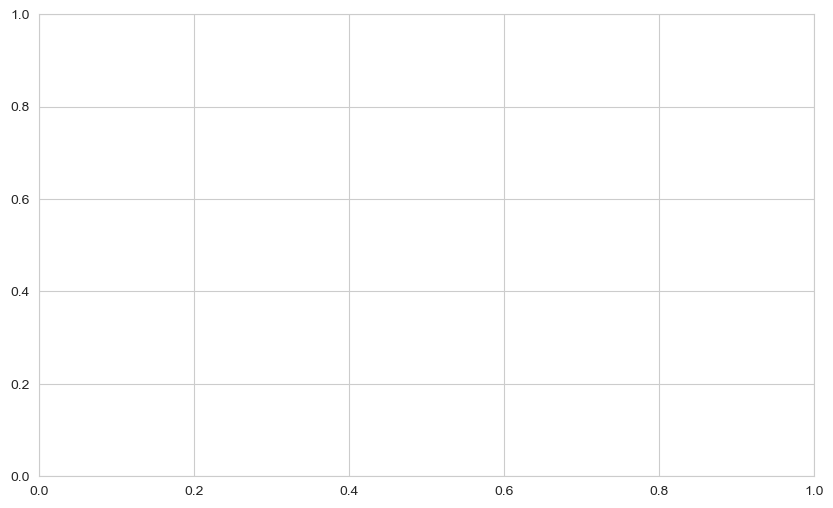

In [34]:
plt.figure(figsize=(10, 6))
set_style("whitegrid")
plt.plot(np.arange(0,len(df_train['Date'])), df_train['Close'], label='Train')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Close price')
plt.legend()
plt.show()